In [2]:
# imports
from sirs import Sirs, SirsSolver

In [3]:
# Setting up pyplot runtime configuration

from matplotlib.ticker import MaxNLocator

SMALL = 14
MEDIUM = 16
LARGE = 20
THICK = 4
THIN = 3
ONE_TIMES_ONE = (9,8)
TWO_TIMES_ONE = (20,8)
TWO_TIMES_TWO = (20,15)
OPACITY = .25


plt.style.context('fivethirtyeight')
plt.rc('axes', facecolor='#E6E6E6', edgecolor='black', axisbelow=True, grid=True)
plt.rc('grid', color='white', linestyle='solid')
plt.rc('lines', linewidth=THICK)

plt.rc('font', size=MEDIUM, weight='bold')          # default text sizes
plt.rc('axes', titlesize=MEDIUM)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM)    # legend fontsize
plt.rc('figure', titlesize=LARGE)  # fontsize of the figure title

COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']

400.0


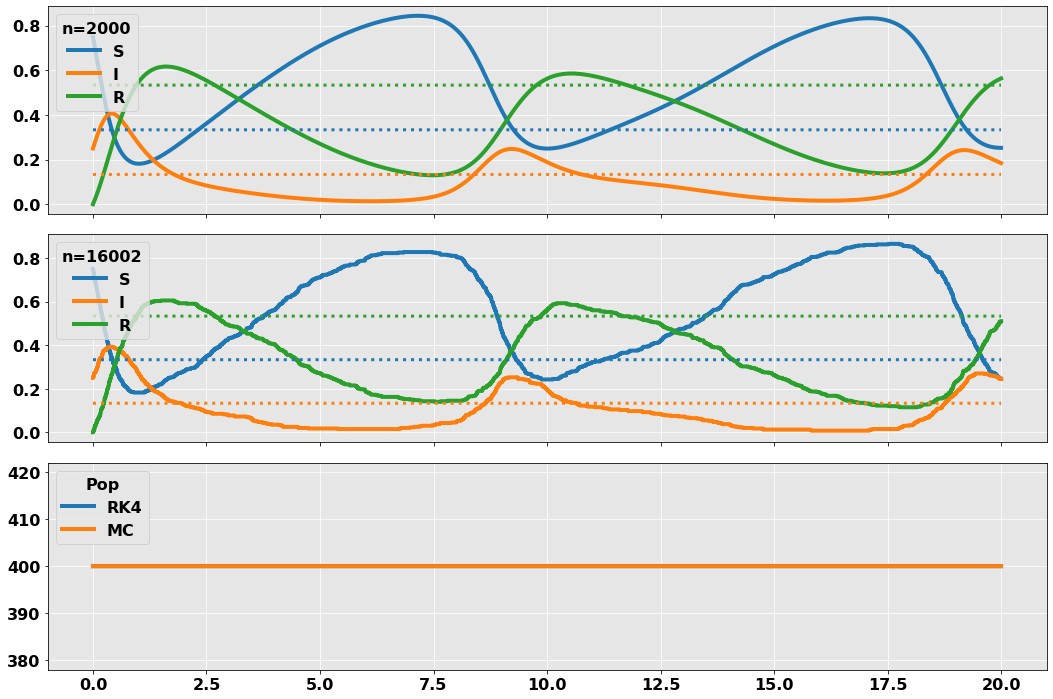

In [28]:
#%%timeit -r 1
t_end = 20

N0 = 400
I0 = 100
A = 2
a = 4
b = 2
c = .5
e = .0
d = .0
dI = .0
F = .0
f = .0

plot_const = True

n = 100*t_end
sirs1 = Sirs(N0, I0, A=A, a=a, b=b, c=c, e=e, d=d, dI=dI, F=F, f=f)
solver1 = SirsSolver(sirs1)
solver1.run_rk4(t_end, n)

sirs2 = Sirs(N0, I0, A=A, a=a, b=b, c=c, e=e, d=d, dI=dI, F=F, f=f)
solver2 = SirsSolver(sirs2)
solver2.run_mc(t_end, seed=5)


fig, axes = plt.subplots(ncols=1, nrows=3, sharex=True, figsize=(15,10))

ax = axes[0]
S, I, R = solver1.get_fractions()
ax.plot(solver1.t, S)
ax.plot(solver1.t, I)
ax.plot(solver1.t, R)
ax.legend(['S', 'I', 'R'], title=f'n={n}', loc='upper left')
if plot_const:
    s, i, r = sirs1.constant_fractions()
    ax.plot(solver1.t, np.zeros(n+1) + s, ':', color=COLORS[0], lw=3)
    ax.plot(solver1.t, np.zeros(n+1) + i, ':', color=COLORS[1], lw=3)
    ax.plot(solver1.t, np.zeros(n+1) + r, ':', color=COLORS[2], lw=3)


ax = axes[1]
S, I, R = solver2.get_fractions()
nt = len(solver2.t)
ax.plot(solver2.t, S)
ax.plot(solver2.t, I)
ax.plot(solver2.t, R)
ax.legend(['S', 'I', 'R'], title=f'n={nt}', loc='upper left')
if plot_const:
    s, i, r = sirs2.constant_fractions()
    ax.plot(solver2.t, np.zeros(nt) + s, ':', color=COLORS[0], lw=3)
    ax.plot(solver2.t, np.zeros(nt) + i, ':', color=COLORS[1], lw=3)
    ax.plot(solver2.t, np.zeros(nt) + r, ':', color=COLORS[2], lw=3)


ax = axes[2]
ax.plot(solver1.t, solver1.res['N'])
ax.plot(solver2.t, solver2.res['N'])
ax.legend(['RK4', 'MC'], title=f'Pop', loc='upper left')
print(solver2.res['N'].max())

plt.tight_layout()
plt.show()

In [22]:
(solver2.t[1:] - solver2.t[:-1]).min(), (solver2.t[1:] - solver2.t[:-1]).max()

(0.0012499999999988631, 0.0012500000000006395)